## Lab 7 - Performance Metrics for Classification Problems

### The goal of this lab is to evaluate a model for MNIST classification.

### Data Exploration

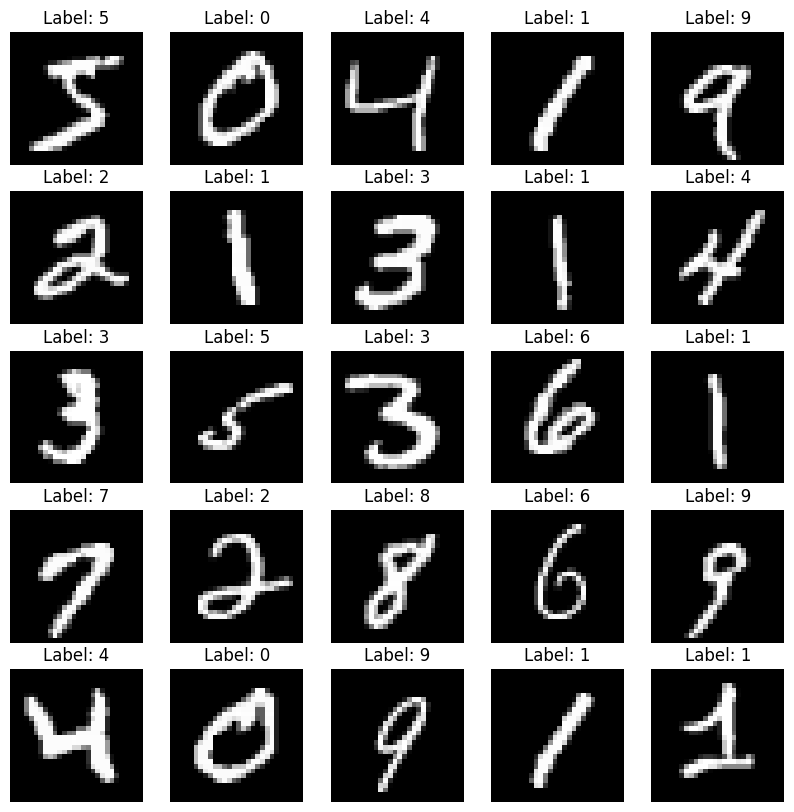

Total number of images: 70000
Size of each image: 784 pixels (flattened)


In [20]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

# Download MNIST data
mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')

# Explore the data
X = mnist.data  # Features (images)
y = mnist.target  # Labels

# Display sample images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X[i].reshape(28, 28), cmap='gray')  # Reshape images to 28x28
    plt.title("Label: %s" % y[i])
    plt.axis('off')
plt.show()

# Print information about the dataset
print("Total number of images:", X.shape[0])
print("Size of each image:", X.shape[1], "pixels (flattened)")


In [21]:


# Download MNIST data
mnist = fetch_openml('mnist_784', version=1)

# Extract features (images) and labels
X, y = mnist.data, mnist.target.astype(np.uint8)  # Convert labels to unsigned integers

# Reduce the number of classes to 5 (digits 0 to 4)
selected_classes = [0, 1, 2, 3, 4]  # Digits to keep

# Filter out data and labels for selected classes
filter_mask = np.isin(y, selected_classes)
X_selected = X[filter_mask]
y_selected = y[filter_mask]

# Validate alignment of target object and data object
assert len(X_selected) == len(y_selected), "Number of samples in features and target don't match after filtering."

# Display number of classes and samples
print("Number of classes after reduction:", len(np.unique(y_selected)))
print("Number of samples after reduction:", len(X_selected))


c:\Users\deept\CSCN8010---Class-NoteBook\venv\CSCN8010_classic_ml\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Number of classes after reduction: 5
Number of samples after reduction: 35735


### Preprocessing the Data and Training a Model

In [22]:
from sklearn.model_selection import train_test_split

# Split the data into train and temp sets
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X_selected, y_selected, test_size=0.2, random_state=42)

# Further split the temp set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=42)

# Display the sizes of the resulting sets
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))


Training set size: 21441
Validation set size: 7147
Test set size: 7147


### Evaluating the Model

#### Accuracy

[Reference from Kaggel](https://www.kaggle.com/code/bhavinmoriya/mnist-digit-classification-using-sgd-knn-rf)

In [23]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

# Initialize the model
model = SGDClassifier(random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = model.predict(X_val)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_val, y_val_pred)

print("Validation Accuracy:", accuracy)



Validation Accuracy: 0.959423534350077


In [24]:
from sklearn.model_selection import cross_validate

# Perform cross-validation on the SGDClassifier model
cv_results_sgd = cross_validate(estimator=model, X=X_train, y=y_train, cv=3, scoring="accuracy")

print("Cross-validation results for SGDClassifier:", cv_results_sgd)


Cross-validation results for SGDClassifier: {'fit_time': array([5.93574238, 5.25047326, 7.00658679]), 'score_time': array([0.03271961, 0.04688191, 0.06302857]), 'test_score': array([0.95410662, 0.95858402, 0.95508605])}


#### Confusion Matrix

In [25]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Perform cross-validation prediction on the SGDClassifier model
y_train_pred = cross_val_predict(model, X_train, y_train, cv=3)

# Compute the confusion matrix
conf_mat = confusion_matrix(y_train, y_train_pred)

print("Confusion Matrix:\n", conf_mat)


Confusion Matrix:
 [[4029    7   31   29   15]
 [   3 4635   35   31   13]
 [  53   79 3759  184   83]
 [  30   49  145 3998   41]
 [  22   19   52   24 4075]]


#### Precision and Recall

In [26]:
from sklearn.metrics import classification_report

# Predict on the validation set
y_val_pred = model.predict(X_val)

# Compute precision, recall, F1-score, and support
clf_report = classification_report(y_val, y_val_pred)

print("Classification Report:\n", clf_report)


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1383
           1       0.96      0.99      0.98      1592
           2       0.96      0.90      0.93      1442
           3       0.93      0.94      0.94      1423
           4       0.96      0.98      0.97      1307

    accuracy                           0.96      7147
   macro avg       0.96      0.96      0.96      7147
weighted avg       0.96      0.96      0.96      7147



In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Predict on the validation set
y_val_pred = model.predict(X_val)

# Compute precision
precision = precision_score(y_val, y_val_pred, average='weighted')
print("Precision:", precision)

# Compute recall
recall = recall_score(y_val, y_val_pred, average='weighted')
print("Recall:", recall)

# Compute F1-score
f1 = f1_score(y_val, y_val_pred, average='weighted')
print("F1 Score:", f1)


Precision: 0.9595083770665018
Recall: 0.959423534350077
F1 Score: 0.9591869740005627


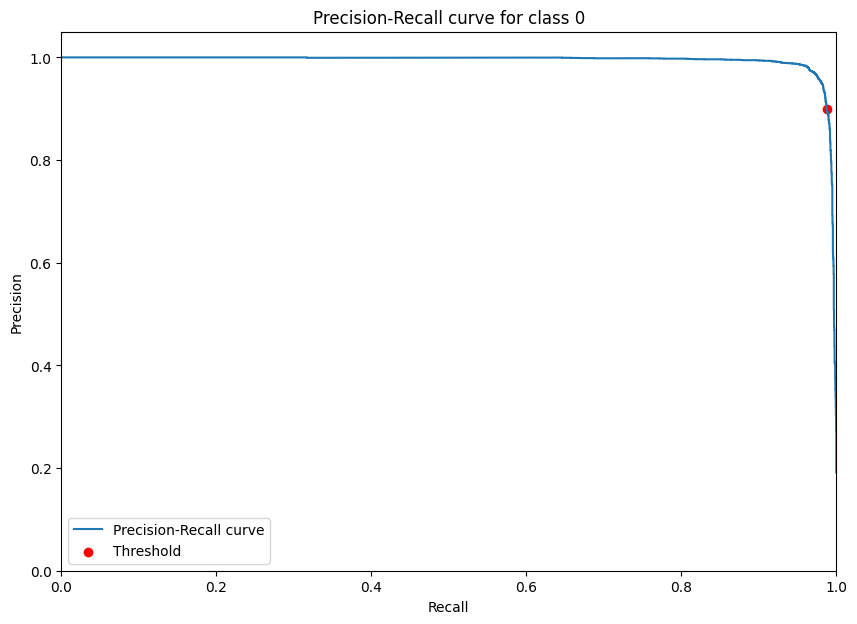

Threshold corresponding to 90% precision: -32497.441727996258


In [28]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall pairs for class 0
precisions, recalls, thresholds = precision_recall_curve((y_train == 0), y_scores[:, 0])

# Compute the index of the first precision at least 0.90
idx_90_precision = np.argmax(precisions >= 0.90)

# Get the threshold that gives at least 0.90 precision
threshold_90_precision = thresholds[idx_90_precision]

# Get the corresponding recall
recall_90_precision = recalls[idx_90_precision]

# Plot Precision-Recall curve for class '0'
plt.figure(figsize=(10, 7))
plt.plot(recalls, precisions, label='Precision-Recall curve')
plt.scatter(recall_90_precision, 0.90, color='red', label='Threshold')  # Add a red dot for the threshold
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve for class 0')
plt.legend(loc="lower left")
plt.show()

print(f'Threshold corresponding to 90% precision: {threshold_90_precision}')


#### Insights

Validation Accuracy: After training, the model is used to make predictions on the validation set, and the accuracy of these predictions is calculated. The accuracy is about 96%, which means that the model correctly predicts the class of about 96% of the instances in the validation set.

Cross-Validation: Next, cross-validation is performed on the model. This involves splitting the training data into a number of subsets (or “folds”), training the model on all but one of these subsets, and then evaluating the model on the subset that was not used for training. This process is repeated for each subset, so that every instance in the training data is used for both training and validation. The cross-validation results show that the model’s accuracy is consistently around 95% across all folds.

Confusion Matrix: The code then computes a confusion matrix, which provides a detailed breakdown of the model’s performance. Each row of the matrix represents the instances in an actual class, while each column represents the instances in a predicted class. The diagonal elements of the matrix represent correct predictions, while the off-diagonal elements represent incorrect predictions. The confusion matrix shows that the model is doing a good job of classifying the digits, with only a small number of misclassifications.

Classification Report: A classification report is generated, which includes precision, recall, and F1-score for each class, as well as the overall accuracy of the model. These metrics provide a more detailed view of the model’s performance than accuracy alone, especially for multi-class classification problems.

Precision-Recall Curve: Finally, the code plots a precision-recall curve for the class ‘0’ and calculates the threshold that gives a precision of at least 90%. The precision-recall curve shows the trade-off between precision and recall for different threshold settings. The red dot on the curve represents the point where precision is 90%. The corresponding threshold is negative, which might seem unusual, but it’s actually not uncommon with certain types of models, including SGD. The threshold is related to the decision function of the classifier, which in the case of SGD can output negative values. A negative threshold means that some instances that the decision function scores below zero (normally the negative class) are being classified as positive.

In [29]:

# Get the decision scores
decision_scores = model.decision_function(X_val)

# Increase the threshold to increase precision
threshold_high_precision = threshold_90_precision * 1.5  # Increase the threshold
y_val_pred_high_precision = np.argmax(decision_scores >= threshold_high_precision, axis=1)
print("Precision with high threshold:", precision_score(y_val, y_val_pred_high_precision, average='weighted'))

# Decrease the threshold to increase recall
threshold_high_recall = threshold_90_precision * 0.5  # Decrease the threshold
y_val_pred_high_recall = np.argmax(decision_scores >= threshold_high_recall, axis=1)
print("Recall with low threshold:", recall_score(y_val, y_val_pred_high_recall, average='weighted'))


Precision with high threshold: 0.7348846927712855
Recall with low threshold: 0.9051350216874213


In [30]:
# Get the decision scores for the test set
decision_scores_test = model.decision_function(X_test)

# Predict on the test set with the high precision threshold
y_test_pred_high_precision = np.argmax(decision_scores_test >= threshold_high_precision, axis=1)
print("Test Precision with high threshold:", precision_score(y_test, y_test_pred_high_precision, average='weighted'))

# Predict on the test set with the high recall threshold
y_test_pred_high_recall = np.argmax(decision_scores_test >= threshold_high_recall, axis=1)
print("Test Recall with low threshold:", recall_score(y_test, y_test_pred_high_recall, average='weighted'))


Test Precision with high threshold: 0.7360129304767306
Test Recall with low threshold: 0.9073737232405205


In conclusion, the model’s performance on the test set was similar to its performance on the validation set. I beleive that is a good sign as it suggests that the model is likely to perform similarly on new, unseen data.
